In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')  # GUIエラーを回避するためにAggバックエンドを使用
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import unicodedata # 全角を半角に変換するために使用
from joblib import dump
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
import shap
import sys
import os
from sklearn.cluster import KMeans
#import torch
#from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
import argparse
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, MeanShift, Birch
from sklearn.cluster import estimate_bandwidth
from tqdm import tqdm
import japanize_matplotlib
import optuna
import scipy.stats as stats

from datetime import datetime
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100
%matplotlib inline

In [72]:
import logging
# Optunaのロガーを取得
optuna_logger = logging.getLogger('optuna')

# ロギングレベルをWARNING以上に設定
optuna_logger.setLevel(logging.WARNING)

# Model作成

## LightGBM

In [73]:
aggregated_df = pd.read_csv("aggregated_df.csv")

In [74]:
aggregated_df.isnull().sum()

KEY                                                    0
target_amount                                          0
target_amount_tableau                                  0
AVG_MONTHLY_POPULATION                                 0
TABELOG_ID                                             0
SAKAYA_DEALER_NAME                                     2
RST_TITLE                                              0
NEAREST_STATION_INFO                                   5
NEAREST_STATION_INFO_count                             0
DISTANCE_VALUE                                         0
RATING_CNT                                             0
RATING_SCORE                                           0
IS_FAMILY_FRIENDLY                                     0
IS_FRIEND_FRIENDLY                                     0
IS_ALONE_FRIENDLY                                      0
DINNER_INFO                                            0
LUNCH_INFO                                             0
DINNER_PRICE                   

In [75]:
aggregated_df.head()

KEY  target_amount  target_amount_tableau  \
0  2100008-100038          115.0               9.500000   
1  2100008-100075           72.0               6.000000   
2  2100008-100077           17.0               1.416667   
3  2100008-100088          114.0               7.583333   
4  2100008-100124          477.0              40.500000   

   AVG_MONTHLY_POPULATION  TABELOG_ID         SAKAYA_DEALER_NAME  \
0             1153.122639  13047470.0               南青山焼き鳥もつ焼き青山   
1              792.017377  13034295.0                    六本木 豚タツ   
2              818.302181  13154369.0              西麻布barnemesis   
3             5817.798084  13268055.0  阿佐ヶ谷 ライブハウス yellow vision   
4             1139.661995  13105939.0                    一之江 梁山泊   

       RST_TITLE NEAREST_STATION_INFO  NEAREST_STATION_INFO_count  \
0    焼き鳥　もつ焼き　青山                  外苑前                         427   
1      白金三代目 豚タツ                 麻布十番                         770   
2           ネメシス               広尾、六本木                        1473   
3  Yellow Vision           阿佐ケ谷、南阿佐ケ谷                         632   
4        中国酒家 長江                  一之江                         198   

   DISTANCE_VALUE  RATING_CNT  RATING_SCORE  IS_FAMILY_FRIENDLY  \
0           400.0        38.0          3.21                 0.0   
1           400.0        38.0          3.26                 0.0   
2           560.0         6.0          3.00                 0.0   
3            64.0         0.0          0.00                 0.0   
4            80.0        23.0          3.22                 1.0   

   IS_FRIEND_FRIENDLY  IS_ALONE_FRIENDLY  DINNER_INFO  LUNCH_INFO  \
0                 1.0                0.0          1.0         0.0   
1                 1.0                0.0          1.0         0.0   
2                 1.0                1.0          1.0         1.0   
3                 0.0                0.0          0.0         0.0   
4                 1.0                0.0          1.0         1.0   

   DINNER_PRICE  LUNCH_PRICE  HOLIDAY  HOME_PAGE_URL  PHONE_NUM  NUM_SEATS  \
0        4499.5       1499.5      1.0            1.0          1       36.0   
1        6999.5       3999.5      0.0            0.0          1       16.0   
2        5999.0       5999.0      0.0            1.0          0       18.0   
3         999.0        999.0      0.0            1.0          0       23.0   
4        2999.0       2999.0      0.0            0.0          0       90.0   

   AGE_RESTAURANT  CITY  CITY_count CUISINE_CAT_origin  \
0            17.0    港区     11198.0                焼き鳥   
1            18.0    港区     11198.0             しゃぶしゃぶ   
2            23.0    港区     11198.0                 バー   
3             3.0   杉並区      4557.0                その他   
4            15.0  江戸川区      3129.0               中華料理   

                                                menu  \
0                                                NaN   
1  "◇焼酎◇","芋","紫","明るい農村","こく紫","富乃宝山","吉兆宝山","いも...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   average_target_amount_in_length_of_relationship  BAPC_2024  \
0                                         9.583333   4.791667   
1                                         6.000000   9.166667   
2                                         2.428571   2.375000   
3                                         9.500000  12.333333   
4                                        43.363636  53.416667   

        CUISINE_CAT  CUISINE_CAT_1_bread and desert  \
0  japanese cuisine                               0   
1  japanese cuisine                               0   
2               bar                               0   
3             other                               0   
4   chinese cuisine                               0   

   CUISINE_CAT_1_cafe and coffee shop  CUISINE_CAT_1_cafeteria  \
0                                   0                        0   
1       

In [76]:
aggregated_df_orgin = aggregated_df.copy()

In [77]:
aggregated_df = pd.get_dummies(aggregated_df, columns=['CUISINE_CAT_origin'], prefix='CUISINE_CAT')

In [78]:
aggregated_df["CITY"] = aggregated_df["CITY"].fillna(0)

In [79]:
aggregated_df["SAKAYA_DEALER_NAME"] = aggregated_df["SAKAYA_DEALER_NAME"].fillna(0)
aggregated_df["NEAREST_STATION_INFO"] = aggregated_df["NEAREST_STATION_INFO"].fillna(0)
aggregated_df["menu"] = aggregated_df["menu"].fillna(0)

In [80]:
df = aggregated_df[(aggregated_df["target_amount_tableau"]<800) & (aggregated_df["target_amount_tableau"]>=20)]

In [81]:
df["target_amount_tableau"].describe()

count    9531.000000
mean      112.252815
std       132.736370
min        20.000000
25%        33.666667
50%        59.833333
75%       129.416667
max       799.833333
Name: target_amount_tableau, dtype: float64

In [82]:
df

KEY  target_amount  target_amount_tableau  \
4      2100008-100124          477.0              40.500000   
5      2100008-100152         3500.0             277.000000   
6      2100008-100248          473.0              37.500000   
7      2100008-100255          169.0              22.916667   
8      2100008-100273          312.0              22.000000   
...               ...            ...                    ...   
23525  2401200-116360          292.0              56.583333   
23526  2401200-118780          251.0              67.916667   
23528  2401200-123286          464.0              89.250000   
23529  2401200-123546          309.0              56.083333   
23530  2401200-125094           97.0              25.250000   

       AVG_MONTHLY_POPULATION  TABELOG_ID              SAKAYA_DEALER_NAME  \
4                 1139.661995  13105939.0                         一之江 梁山泊   
5                15635.301882  13098922.0                     新宿ねぎし 池袋東口店   
6                 4166.779740  13100784.0                   番番(バンバン) 神谷町店   
7                 1009.211837  13099652.0                    六本木 六七(ロクナナ)   
8                14325.820878  13099879.0                中国名菜 銀座アスター 新宿賓館   
...                       ...         ...                             ...   
23525             3049.072581  13207208.0                    バル&デリ エル・ロセヨ   
23526             1590.312919  13230726.0                          入ル 坂上ル   
23528            15913.471854  13274911.0                   八起庵 東武百貨店 池袋店   
23529             5872.300290  13275861.0              韓国酒場コッキオ グランスタ八重北店   
23530             2495.429860  13293108.0  schoolbuscoffeestopnakameguro店   

                               RST_TITLE NEAREST_STATION_INFO  \
4                                中国酒家 長江                  一之江   
5                              ねぎし 池袋東口店                   池袋   
6                                  焼鶏　番番                  神谷町   
7                                     六七       六本木、乃木坂、六本木一丁目   
8                            銀座アスター 新宿賓館                新宿三丁目   
...                                  ...                  ...   
23525                     バルアンドデリ エル・ロセヨ                 学芸大学   
23526                        韓国食堂 入ル 坂上ル                  恵比寿   
23528                        八起庵 池袋東武百貨店                   池袋   
23529                 韓国酒場コッキオ グランスタ八重北店                   東京   
23530  SCHOOL BUS COFFEE STOP NAKAMEGURO                 池尻大橋   

       NEAREST_STATION_INFO_count  DISTANCE_VALUE  RATING_CNT  RATING_SCORE  \
4                             198            80.0        23.0          3.22   
5                            2564           400.0       239.0          3.22   
6                             293           240.0        57.0          3.04   
7                            1473           400.0        97.0          3.41   
8                            1668           560.0       159.0          3.30   
...                           ...             ...         ...           ...   
23525                         537           160.0        56.0          3.39   
23526                        1534           240.0       280.0          3.51   
23528                        2564            63.0        55.0          3.30   
23529                        1232             0.0       254.0          3.44   
23530                         464           800.0        39.0          3.11   

       IS_FAMILY_FRIENDLY  IS_FRIEND_FRIENDLY  IS_ALONE_FRIENDLY  DINNER_INFO  \
4                     1.0                 1.0                0.0          1.0   
5                     1.0                 1.0                1.0          1.0   
6                     0.0                 1.0                0.0          1.0   
7                     0.0                 1.0                0.0          1.0   
8                     0.0                 1.0                0.0          1.0   
...                   ...                 ...                ...          ...   
23525                 1.0              

<Axes: xlabel='target_amount_tableau', ylabel='Count'>

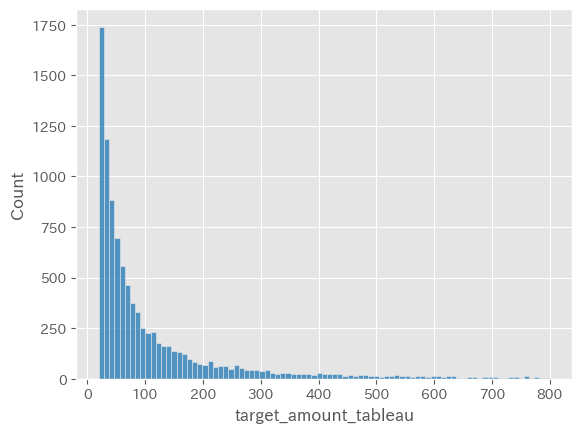

In [83]:
sns.histplot(df["target_amount_tableau"])

In [84]:
from sklearn.preprocessing import KBinsDiscretizer
X = pd.DataFrame(df["target_amount_tableau"])#.reshape(-1, 1) 
est = KBinsDiscretizer(
    n_bins=3, encode='ordinal', strategy='kmeans'
)
est.fit(X)

KBinsDiscretizer(encode='ordinal', n_bins=3, strategy='kmeans')

In [85]:
Xt = est.transform(X)

In [86]:
est.bin_edges_[0]

array([ 20.        , 139.6462554 , 383.90109307, 799.83333333])

In [87]:
Xt[:,0]

array([0., 1., 0., ..., 0., 0., 0.])

In [94]:
# =========================================
# 1) ラベル作成（low/middle/high）と前処理
# =========================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier

# ---- しきい値: low[20,50), middle[50,150), high[150,∞) ----
def make_class_label(y: pd.Series) -> pd.Series:
    bins = [-10, 75, 150, np.inf]   # 区間下端を含む、上端は含まない
    labels = ["low", "middle", "high"]
    # y<20 は通常データに無い想定ですが、もしあれば NaN になります
    y_class = pd.cut(y, bins=bins, labels=labels, right=False)
    return y_class

# ここでは target_amount_tableau を教師にしてクラスを作る
df["y_class"] = make_class_label(df["target_amount_tableau"]).astype("category")

# 学習に使わない列を除外
drop_cols = [
    "KEY", "target_amount_tableau", "RST_TITLE", "menu","target_amount","average_target_amount_in_length_of_relationship","BAPC_2024",
    'TABELOG_ID', 'SAKAYA_DEALER_NAME',
]
use_cols = [c for c in df.columns if c not in drop_cols + ["y_class"]]
print(use_cols)
# 型調整（object→category、bool系はそのまま/0-1化）
X = df[use_cols].copy()

# object列は LightGBM に渡すとき category に変換
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols:
    X[c] = X[c].astype("category")

y = df["y_class"]

# =========================================
# 2) OOF（Out-of-Fold）でクラス確率を推定
# =========================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_proba = np.zeros((len(X), 3), dtype=float)  # [p_low, p_middle, p_high]
models = []

# 不均衡への対処：クラス重み（頻度の逆数）を自動計算
class_counts = y.value_counts()
class_weight = {cls: (len(y) / (len(class_counts) * cnt)) for cls, cnt in class_counts.items()}

for fold, (tr, va) in enumerate(skf.split(X, y)):
    print(fold, len(tr))
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    clf = LGBMClassifier(
        objective="multiclass",
        learning_rate=0.05,
        n_estimators=3000,
        num_leaves=127,
        min_data_in_leaf=10,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        random_state=42 + fold,
        class_weight=class_weight,   # 重み付けで high を取り逃がしにくく
    )
    # LightGBM は pandas の category dtype をそのまま扱えます
    clf.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric="multi_logloss")
    models.append(clf)

    proba = clf.predict_proba(X_va)  # 列順は clf.classes_ の並び
    # 列順を [low, middle, high] に並び替え
    idx_map = [list(clf.classes_).index(k) for k in ["low", "middle", "high"]]
    oof_proba[va, :] = proba[:, idx_map]

# OOF のざっくり評価（high を重視するなら macro F1 など）
y_pred_oof = np.array(["low", "middle", "high"])[oof_proba.argmax(axis=1)]
print(classification_report(y, y_pred_oof, digits=3))
print("Macro F1:", f1_score(y, y_pred_oof, average="macro"))

# 学習完了後の「全学習データでの最終モデル」（推論用）
final_clf = LGBMClassifier(
    objective="multiclass",
    learning_rate=0.05,
    n_estimators=int(np.mean([m.best_iteration_ or 3000 for m in models])),  # OOFでの平均反映（任意）
    num_leaves=127, min_data_in_leaf=10, feature_fraction=0.9,
    bagging_fraction=0.9, bagging_freq=1, random_state=777, class_weight=class_weight
)
final_clf.fit(X, y)

['AVG_MONTHLY_POPULATION', 'NEAREST_STATION_INFO', 'NEAREST_STATION_INFO_count', 'DISTANCE_VALUE', 'RATING_CNT', 'RATING_SCORE', 'IS_FAMILY_FRIENDLY', 'IS_FRIEND_FRIENDLY', 'IS_ALONE_FRIENDLY', 'DINNER_INFO', 'LUNCH_INFO', 'DINNER_PRICE', 'LUNCH_PRICE', 'HOLIDAY', 'HOME_PAGE_URL', 'PHONE_NUM', 'NUM_SEATS', 'AGE_RESTAURANT', 'CITY', 'CITY_count', 'CUISINE_CAT', 'CUISINE_CAT_1_bread and desert', 'CUISINE_CAT_1_cafe and coffee shop', 'CUISINE_CAT_1_cafeteria', 'CUISINE_CAT_1_chinese cuisine', 'CUISINE_CAT_1_convenience store', 'CUISINE_CAT_1_family restaurant', 'CUISINE_CAT_1_fastfood light meal', 'CUISINE_CAT_1_foreign ethnic cuisine', 'CUISINE_CAT_1_hotel and ryokan', 'CUISINE_CAT_1_italian cuisine', 'CUISINE_CAT_1_izakaya', 'CUISINE_CAT_1_japanese cuisine', 'CUISINE_CAT_1_noodles', 'CUISINE_CAT_1_other', 'CUISINE_CAT_1_restaurant', 'rate_count', 'seats_rate_count', 'CUISINE_CAT_num', 'CUISINE_CAT_origin_num', 'CUISINE_CAT_あなご', 'CUISINE_CAT_いなり寿司', 'CUISINE_CAT_うどん', 'CUISINE_CAT_うなぎ',

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1,
               class_weight={'high': 1.566568047337278,
                             'low': 0.569456891916114,
                             'middle': 1.6512474012474012},
               feature_fraction=0.9, learning_rate=0.05, min_data_in_leaf=10,
               n_estimators=3000, num_leaves=127, objective='multiclass',
               random_state=777)

In [95]:
# ============================
# 単純 Train/Test 分割での学習・評価
# ============================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from lightgbm import LGBMClassifier

# ---- しきい値: low[20,50), middle[50,150), high[150,∞) ----
def make_class_label(y: pd.Series) -> pd.Series:
    bins = [0, 75, 150, np.inf]    # 下端を含む, 上端は含まない
    labels = ["low", "middle", "high"]
    return pd.cut(y, bins=bins, labels=labels, right=False)

# ラベル作成 & y<20 等を除外
df = df.copy()
df["y_class"] = make_class_label(df["target_amount_tableau"]).astype("category")
df = df[df["y_class"].notna()].copy()

# 学習に使わない列を除外
drop_cols = ["KEY", "target_amount_tableau", "RST_TITLE", "menu","target_amount","average_target_amount_in_length_of_relationship","BAPC_2024",
    'TABELOG_ID', 'SAKAYA_DEALER_NAME','NEAREST_STATION_INFO',"CITY",]
use_cols = [c for c in df.columns if c not in drop_cols + ["y_class"]]

# 特徴量/目的
X_all = df[use_cols].copy()
y_all = df["y_class"].cat.set_categories(["low", "middle", "high"])

# Train/Test 分割（層化）
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# object列 → category（学習カテゴリ水準にテストを合わせる）
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
train_cat_levels = {}
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    train_cat_levels[c] = X_train[c].cat.categories.tolist()
    X_test[c] = X_test[c].astype("category").cat.set_categories(train_cat_levels[c])

# クラス重み（頻度の逆数）
class_counts = y_train.value_counts()
class_weight = {cls: (len(y_train) / (len(class_counts) * cnt)) for cls, cnt in class_counts.items()}

# モデル学習
clf = LGBMClassifier(
    objective="multiclass",
    learning_rate=0.05,
    n_estimators=3000,
    num_leaves=127,
    min_data_in_leaf=10,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    random_state=42,
    class_weight=class_weight,
)
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="multi_logloss")

# 予測（確率は classes_ の順 → ["low","middle","high"] に並べ替え）
ORDER = ["low", "middle", "high"]
idx_map = [list(clf.classes_).index(k) for k in ORDER]
proba_test = clf.predict_proba(X_test)[:, idx_map]
pred_idx = proba_test.argmax(axis=1)
y_pred = pd.Categorical(np.array(ORDER)[pred_idx], categories=ORDER)

# 評価
print(classification_report(y_test, y_pred, labels=ORDER, digits=3))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred, labels=ORDER))

# テストデータに予測カラムを付与
df_test_scored = df.loc[X_test.index].copy()
df_test_scored["p_low"] = proba_test[:, 0]
df_test_scored["p_middle"] = proba_test[:, 1]
df_test_scored["p_high"] = proba_test[:, 2]
df_test_scored["pred_class"] = y_pred
df_test_scored["pred_confidence"] = proba_test.max(axis=1)

# df_test_scored が、予測付きのテストデータフレームです。

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value:

In [90]:
# 全体の予測

In [91]:
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric="multi_logloss")

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value:

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1,
               class_weight={'high': 2.183276059564719,
                             'low': 0.5694226603928598,
                             'middle': 1.272575529961609},
               feature_fraction=0.9, learning_rate=0.05, min_data_in_leaf=10,
               n_estimators=3000, num_leaves=127, objective='multiclass',
               random_state=42)

In [92]:
df

KEY  target_amount  target_amount_tableau  \
4      2100008-100124          477.0              40.500000   
5      2100008-100152         3500.0             277.000000   
6      2100008-100248          473.0              37.500000   
7      2100008-100255          169.0              22.916667   
8      2100008-100273          312.0              22.000000   
...               ...            ...                    ...   
23525  2401200-116360          292.0              56.583333   
23526  2401200-118780          251.0              67.916667   
23528  2401200-123286          464.0              89.250000   
23529  2401200-123546          309.0              56.083333   
23530  2401200-125094           97.0              25.250000   

       AVG_MONTHLY_POPULATION  TABELOG_ID              SAKAYA_DEALER_NAME  \
4                 1139.661995  13105939.0                         一之江 梁山泊   
5                15635.301882  13098922.0                     新宿ねぎし 池袋東口店   
6                 4166.779740  13100784.0                   番番(バンバン) 神谷町店   
7                 1009.211837  13099652.0                    六本木 六七(ロクナナ)   
8                14325.820878  13099879.0                中国名菜 銀座アスター 新宿賓館   
...                       ...         ...                             ...   
23525             3049.072581  13207208.0                    バル&デリ エル・ロセヨ   
23526             1590.312919  13230726.0                          入ル 坂上ル   
23528            15913.471854  13274911.0                   八起庵 東武百貨店 池袋店   
23529             5872.300290  13275861.0              韓国酒場コッキオ グランスタ八重北店   
23530             2495.429860  13293108.0  schoolbuscoffeestopnakameguro店   

                               RST_TITLE NEAREST_STATION_INFO  \
4                                中国酒家 長江                  一之江   
5                              ねぎし 池袋東口店                   池袋   
6                                  焼鶏　番番                  神谷町   
7                                     六七       六本木、乃木坂、六本木一丁目   
8                            銀座アスター 新宿賓館                新宿三丁目   
...                                  ...                  ...   
23525                     バルアンドデリ エル・ロセヨ                 学芸大学   
23526                        韓国食堂 入ル 坂上ル                  恵比寿   
23528                        八起庵 池袋東武百貨店                   池袋   
23529                 韓国酒場コッキオ グランスタ八重北店                   東京   
23530  SCHOOL BUS COFFEE STOP NAKAMEGURO                 池尻大橋   

       NEAREST_STATION_INFO_count  DISTANCE_VALUE  RATING_CNT  RATING_SCORE  \
4                             198            80.0        23.0          3.22   
5                            2564           400.0       239.0          3.22   
6                             293           240.0        57.0          3.04   
7                            1473           400.0        97.0          3.41   
8                            1668           560.0       159.0          3.30   
...                           ...             ...         ...           ...   
23525                         537           160.0        56.0          3.39   
23526                        1534           240.0       280.0          3.51   
23528                        2564            63.0        55.0          3.30   
23529                        1232             0.0       254.0          3.44   
23530                         464           800.0        39.0          3.11   

       IS_FAMILY_FRIENDLY  IS_FRIEND_FRIENDLY  IS_ALONE_FRIENDLY  DINNER_INFO  \
4                     1.0                 1.0                0.0          1.0   
5                     1.0                 1.0                1.0          1.0   
6                     0.0                 1.0                0.0          1.0   
7                     0.0                 1.0                0.0          1.0   
8                     0.0                 1.0                0.0          1.0   
...                   ...                 ...                ...          ...   
23525                 1.0              

In [34]:
use_cols

['AVG_MONTHLY_POPULATION',
 'NEAREST_STATION_INFO_count',
 'DISTANCE_VALUE',
 'RATING_CNT',
 'RATING_SCORE',
 'IS_FAMILY_FRIENDLY',
 'IS_FRIEND_FRIENDLY',
 'IS_ALONE_FRIENDLY',
 'DINNER_INFO',
 'LUNCH_INFO',
 'DINNER_PRICE',
 'LUNCH_PRICE',
 'HOLIDAY',
 'HOME_PAGE_URL',
 'PHONE_NUM',
 'NUM_SEATS',
 'AGE_RESTAURANT',
 'CITY_count',
 'CUISINE_CAT',
 'CUISINE_CAT_1_bread and desert',
 'CUISINE_CAT_1_cafe and coffee shop',
 'CUISINE_CAT_1_cafeteria',
 'CUISINE_CAT_1_chinese cuisine',
 'CUISINE_CAT_1_convenience store',
 'CUISINE_CAT_1_family restaurant',
 'CUISINE_CAT_1_fastfood light meal',
 'CUISINE_CAT_1_foreign ethnic cuisine',
 'CUISINE_CAT_1_hotel and ryokan',
 'CUISINE_CAT_1_italian cuisine',
 'CUISINE_CAT_1_izakaya',
 'CUISINE_CAT_1_japanese cuisine',
 'CUISINE_CAT_1_noodles',
 'CUISINE_CAT_1_other',
 'CUISINE_CAT_1_restaurant',
 'rate_count',
 'seats_rate_count',
 'CUISINE_CAT_num',
 'CUISINE_CAT_origin_num',
 'CUISINE_CAT_あなご',
 'CUISINE_CAT_いなり寿司',
 'CUISINE_CAT_うどん',
 'CUISINE_

In [45]:
df_test_scored

KEY  target_amount  target_amount_tableau  \
8915    2100014-5600408         1084.0             207.833333   
12747      2100017-6214          282.0              20.500000   
22554  2100915-46648100          123.0              41.833333   
18902    2100048-220010          374.0             140.416667   
13889     2100020-18174          371.0              77.500000   
...                 ...            ...                    ...   
97       2100008-103673          364.0              28.750000   
1027     2100008-617368          696.0              48.916667   
1348     2100008-655596          918.0              66.333333   
15355      2100026-3472         3136.0             698.750000   
19597      2100054-3202         1620.0             142.500000   

       AVG_MONTHLY_POPULATION  TABELOG_ID          SAKAYA_DEALER_NAME  \
8915              6644.508927  13166575.0            牛の達人private新宿本店◇   
12747             7265.459798  13115903.0                      laface   
22554            18266.456343  13247415.0       鳥茂分店(焼きとん/虎ノ門ビジネスタワー)   
18902             3224.435697  13244567.0                    シロナガスクジラ   
13889            53185.003050  13156065.0                 handbakes新宿   
...                       ...         ...                         ...   
97                5628.319460  13133616.0                       銀座 照庵   
1027              3349.296388  13111145.0                    馬喰ろう 新橋店   
1348              3881.794380  13191125.0  rainbow カフェ&ワイン ダイニング 下北沢店   
15355              861.235975  13016869.0                     もんじゃ七五三   
19597             5276.141849  13213087.0                     品川ときしらず   

                      RST_TITLE NEAREST_STATION_INFO  \
8915     完全個室 牛の達人 private 新宿本店                 西武新宿   
12747                     ラフェイス                   葛西   
22554                     鳥茂 分店               虎ノ門ヒルズ   
18902           博多餃子酒場 シロナガスクジラ                  飯田橋   
13889         HAND BAKES ルミネ新宿店                   新宿   
...                         ...                  ...   
97                    おそば　照庵　銀座            内幸町、銀座、新橋   
1027                   馬喰ろう 新橋店                  内幸町   
1348   CAFE＆WINE DINING RAINBOW                  下北沢   
15355                       七五三           浅草（つくばＥＸＰ）   
19597                 ときしらず 品川店                   品川   

       NEAREST_STATION_INFO_count  DISTANCE_VALUE  RATING_CNT  RATING_SCORE  \
8915                         1146            80.0       258.0          3.30   
12747                         478            39.9         9.0          3.03   
22554                         359           231.0       213.0          3.63   
18902                         965           241.0        30.0          3.23   
13889                        1304            80.0       238.0          3.45   
...                           ...             ...         ...           ...   
97                           2350           376.0        86.0          3.26   
1027                          989           560.0       172.0          3.23   
1348                          802           197.0        74.0          3.34   
15355                        1393           240.0       316.0          3.49   
19597                         517           240.0       112.0          3.26   

       IS_FAMILY_FRIENDLY  IS_FRIEND_FRIENDLY  IS_ALONE_FRIENDLY  DINNER_INFO  \
8915                  1.0                 1.0                0.0          1.0   
12747                 0.0                 1.0                0.0          1.0   
22554                 0.0                 0.0                0.0          1.0   
18902                 0.0                 0.0                0.0          0.0   
13889                 1.0                 1.0                0.0          1.0   
...                   ...                 ...                ...          ...   
97                    0.0                 1.0                1.0          1.0   
1027                  0.0                 1.0                0.0          1.0   
1348       

## オリジナルデータの分布

In [46]:
summary_stats = df_test_scored.groupby('y_class')['target_amount_tableau'].agg(
    data_count='count',
    mean='mean',
    std='std',
    kurtosis=lambda x: stats.kurtosis(x),
    min='min',
    q25=lambda x: x.quantile(0.25),
    median='median',
    q75=lambda x: x.quantile(0.75),
    max='max'
)
summary_stats.sort_values(by='data_count', ascending=False).head(100)

data_count        mean         std  kurtosis    min         q25  \
y_class                                                                    
low            1116   39.829824   14.853801 -0.760305   20.0   26.479167   
middle          500  120.469167   34.172164 -0.869294   75.0   90.395833   
high            291  381.607388  160.622460 -0.292678  200.0  254.208333   

             median         q75         max  
y_class                                      
low       37.041667   50.833333   74.916667  
middle   112.083333  146.312500  198.000000  
high     323.333333  486.000000  796.500000

In [47]:
y_pred_oof = np.array(["low", "middle", "high"])[oof_proba.argmax(axis=1)]
print(classification_report(y, y_pred_oof, digits=3))
print("Macro F1:", f1_score(y, y_pred_oof, average="macro"))

              precision    recall  f1-score   support

        high      0.388     0.214     0.276      1455
         low      0.650     0.852     0.738      5579
      middle      0.344     0.195     0.249      2497

    accuracy                          0.583      9531
   macro avg      0.461     0.420     0.421      9531
weighted avg      0.530     0.583     0.539      9531

Macro F1: 0.4207938019859892


In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred_oof)

array([[ 311,  804,  340],
       [ 233, 4756,  590],
       [ 257, 1753,  487]])

In [49]:
df["pred_class"] = y_pred_oof

In [50]:
summary_stats = df.groupby('y_class')['target_amount_tableau'].agg(
    data_count='count',
    mean='mean',
    std='std',
    kurtosis=lambda x: stats.kurtosis(x),
    min='min',
    q25=lambda x: x.quantile(0.25),
    median='median',
    q75=lambda x: x.quantile(0.75),
    max='max'
)
summary_stats.sort_values(by='data_count', ascending=False).head(100)

data_count        mean         std  kurtosis    min         q25  \
y_class                                                                    
low            5579   40.076388   15.298693 -0.821503   20.0   26.666667   
middle         2497  121.195268   34.177526 -0.840316   75.0   91.166667   
high           1455  373.656930  155.152387 -0.029140  200.0  249.708333   

         median         q75         max  
y_class                                  
low       36.75   51.458333   74.916667  
middle   114.00  146.583333  199.833333  
high     319.00  461.833333  799.833333

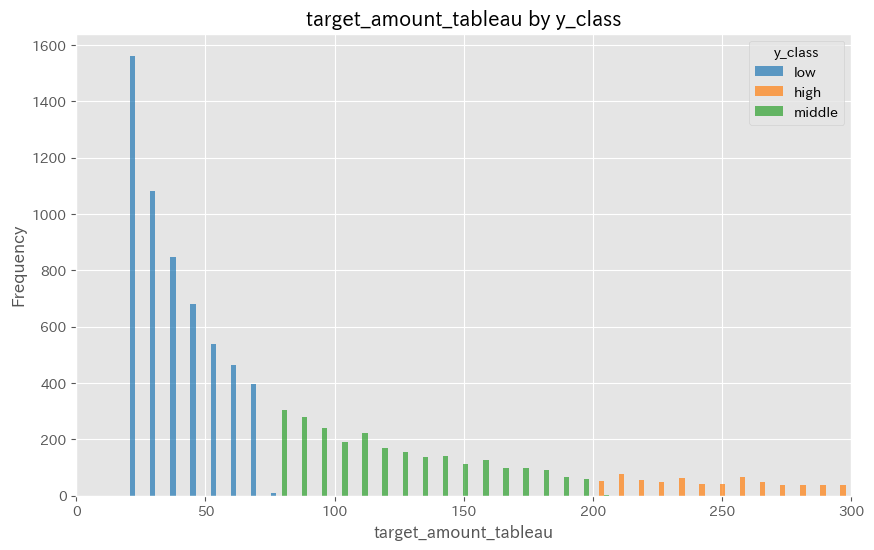

In [51]:
# スタイル設定
plt.style.use('ggplot')
sns.set_palette("tab10") # Seabornのカラーパレットを使用

# クラスターごとのデータのリストを作成
clusters = df["y_class"].unique()
data_by_cluster = [df[df['y_class'] == c]["target_amount_tableau"] for c in clusters]

# ヒストグラムの描画
plt.figure(figsize=(10, 6))
plt.hist(data_by_cluster,
         bins=100, # ビンの数を設定
         label=clusters,
         alpha=0.7, # 透過度
         rwidth=0.8) # ビンの幅を調整

# 凡例、タイトル、ラベルを追加
plt.legend(title="y_class")
plt.title("target_amount_tableau by y_class")
plt.xlabel("target_amount_tableau")
plt.ylabel("Frequency")
plt.xlim(0, 300)
# グラフを表示
plt.show()

In [52]:
summary_stats = df.groupby('pred_class')['target_amount_tableau'].agg(
    data_count='count',
    mean='mean',
    std='std',
    kurtosis=lambda x: stats.kurtosis(x),
    min='min',
    q25=lambda x: x.quantile(0.25),
    median='median',
    q75=lambda x: x.quantile(0.75),
    max='max'
)
summary_stats.sort_values(by='data_count', ascending=False).head(100)

data_count        mean         std   kurtosis   min        q25  \
pred_class                                                                   
low               7313   93.742297  111.864462  10.227533  20.0  31.083333   
middle            1417  153.469419  160.520690   3.707851  20.0  48.750000   
high               801  208.337079  185.791673   0.833449  20.0  65.916667   

                median         q75         max  
pred_class                                      
low          51.583333  104.750000  799.833333  
middle       92.333333  191.583333  792.833333  
high        141.833333  300.500000  793.250000

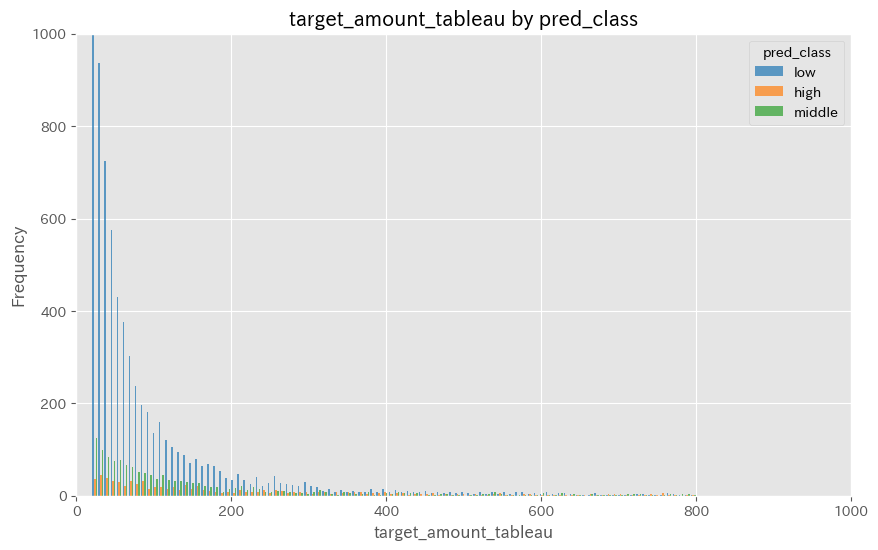

In [53]:
# スタイル設定
plt.style.use('ggplot')
sns.set_palette("tab10") # Seabornのカラーパレットを使用

# クラスターごとのデータのリストを作成
clusters = df["pred_class"].unique()
data_by_cluster = [df[df['pred_class'] == c]["target_amount_tableau"] for c in clusters]

# ヒストグラムの描画
plt.figure(figsize=(10, 6))
plt.hist(data_by_cluster,
         bins=100, # ビンの数を設定
         label=clusters,
         alpha=0.7, # 透過度
         rwidth=0.8) # ビンの幅を調整

# 凡例、タイトル、ラベルを追加
plt.legend(title="pred_class")
plt.title("target_amount_tableau by pred_class")
plt.xlabel("target_amount_tableau")
plt.ylabel("Frequency")
plt.xlim(0, 1000)
plt.ylim(0,1000)
# グラフを表示
plt.show()

In [44]:
aggregated_df = aggregated_df[~(aggregated_df["CUISINE_CAT"]=="convenience store")]

In [261]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. データの準備 (ダミーデータを使用) ---
data = aggregated_df.drop(["KEY",'TABELOG_ID','SAKAYA_DEALER_NAME', 'RST_TITLE',"target_amount"],axis=1)
X = data.drop( "average_target_amount_in_length_of_relationship",axis=1)
y = data["average_target_amount_in_length_of_relationship"]

print("--- データ概要 ---")
print("特徴量 (X) の先頭5行:\n", X.head())
print("\nターゲット変数 (y) の先頭5行:\n", y.head())
print(f"\n特徴量 (X) の形状: {X.shape}")
print(f"ターゲット変数 (y) の形状: {y.shape}")

# --- 2. 訓練データとテストデータに分割 ---
# データを訓練用とテスト用に80:20の比率で分割
# random_state を固定することで、毎回同じ分割結果が得られる
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- データ分割後 ---")
print(f"訓練データ (X_train) の形状: {X_train.shape}")
print(f"テストデータ (X_test) の形状: {X_test.shape}")

# --- 3. RandomForestRegressorモデルのベースインスタンスを準備 ---
# ここでは、具体的なハイパーパラメータは指定せず、グリッドサーチに任せる
base_model = RandomForestRegressor(random_state=42)

# --- 4. 探索するハイパーパラメータのグリッドを定義 ---
# ここで探索したいパラメータとその候補値を指定します。
# 辞書のキーがパラメータ名、値が候補値のリストです。
param_grid = {
    'n_estimators': [200],         # 決定木の数
    'max_depth': [10],           # 木の最大深度 (Noneは制限なし)
    'min_samples_split': [2, 5, 10],       # 分割するためにノードに必要な最小サンプル数
    'min_samples_leaf': [2, 4]          # リーフノードに必要な最小サンプル数
}
# 注意: パラメータ候補の組み合わせが多すぎると計算に非常に時間がかかります。
# 最初の探索では粗いグリッドで、良い範囲が見つかったら細かいグリッドで再探索するのが一般的です。

print("\n--- グリッドサーチ設定 ---")
print("探索するハイパーパラメータのグリッド:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# --- 5. GridSearchCV のインスタンスを作成 ---
# estimator: チューニング対象のモデル
# param_grid: 探索するハイパーパラメータのグリッド
# cv: 交差検定の分割数 (例: 5分割交差検定)
# scoring: モデルの評価指標 (回帰では 'neg_mean_squared_error' または 'r2')
#          'neg_mean_squared_error' はMSEを最小化するために負の値で返されます。
# n_jobs: 並列処理に使うCPUコア数 (-1は全コアを使用)
# verbose: ログの表示レベル (数字を大きくすると詳細になる)
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,                             # 5分割交差検定
    scoring='neg_mean_squared_error', # 評価指標 (MSEを最小化したいので負の値)
    n_jobs=-1,                        # 利用可能な全CPUコアを使用
    verbose=2                         # ログを詳細に表示
)

# --- 6. グリッドサーチを実行 (最適なパラメータの探索) ---
print("\n--- グリッドサーチ開始 ---")
grid_search.fit(X_train, y_train)
print("--- グリッドサーチ完了 ---")

# --- 7. 最適なハイパーパラメータと最高のスコアを取得 ---
print("\n--- グリッドサーチ結果 ---")
print(f"最適なハイパーパラメータ: {grid_search.best_params_}")
# 'neg_mean_squared_error' は負の値なので、-1をかけて正のMSEに戻す
print(f"交差検定でのベストスコア (MSE): {-grid_search.best_score_:.4f}")

# --- 8. 最適なモデルを取得し、テストデータで最終評価 ---
best_model = grid_search.best_estimator_

print("\n--- 最適モデルのテストデータでの評価 ---")
y_pred_best = best_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"テストデータでの平均二乗誤差 (MSE): {mse_best:.4f}")
print(f"テストデータでの二乗平均平方根誤差 (RMSE): {rmse_best:.4f}")
print(f"テストデータでの決定係数 (R^2 Score): {r2_best:.4f}")

# --- 9. (オプション) 最適モデルの特徴量の重要度 ---
print("\n--- 最適モデルの特徴量の重要度 ---")
feature_importances_best = pd.Series(best_model.feature_importances_, index=X.columns)
print(feature_importances_best.sort_values(ascending=False))

--- データ概要 ---
特徴量 (X) の先頭5行:
    AVG_MONTHLY_POPULATION  NEAREST_STATION_INFO  DISTANCE_VALUE  RATING_CNT  \
0             1153.122639                 324.0           400.0        38.0   
1              792.017377                 619.0           400.0        38.0   
2              818.302181                   9.0           560.0         6.0   
3             5817.798084                  44.0            64.0         0.0   
4             1139.661995                  25.0            80.0        23.0   

   RATING_SCORE  IS_FAMILY_FRIENDLY  IS_FRIEND_FRIENDLY  IS_ALONE_FRIENDLY  \
0          3.21                 0.0                 1.0                0.0   
1          3.26                 0.0                 1.0                0.0   
2          3.00                 0.0                 1.0                1.0   
3          0.00                 0.0                 0.0                0.0   
4          3.22                 1.0                 1.0                0.0   

   DINNER_INFO  LUNCH_INFO

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/pandas/core/generic.py", line 2168, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'chinese cuisine'

--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 348, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/katonaoto/py311env/lib/python3.11/site-packages/pandas/core/generic.py", line 2168, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'japanese cuisine'


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x=y_test, y=y_pred_best,
                s=70, # マーカーサイズ
                alpha=0.1) # 透明度
plt.plot(range(0,100),range(0,100))